<a href="https://colab.research.google.com/github/Pranesh1306/Pranesh1306/blob/main/optic_disc_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    image = image / 255.0  # Normalize by dividing by 255
    return image

def preprocess_label(label_path, target_size):
    label = cv2.imread(label_path)
    label = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    label = label / 255.0  # Normalize by dividing by 255
    return label

import os
from PIL import Image

def preprocess_data(image_folder, label_folder, target_size):
    # Get sorted lists of image and label files
    image_files = sorted(os.listdir(image_folder))
    label_files = sorted(os.listdir(label_folder))

    images = []
    labels = []

    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file)

        image = preprocess_image(image_path, target_size)
        label = preprocess_image(label_path, target_size)

        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [3]:
# Paths to the image and label folders
import zipfile
zip_file_path_1 = "images.zip"
zip_file_path_2 = "labels.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path_1, 'r') as zip_ref:
    zip_ref.extractall('images')  # Extract to the 'images' directory
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path_2, 'r') as zip_ref:
    zip_ref.extractall('labels')  # Extract to the 'images' directory


In [4]:
image_folder = "/content/images"
label_folder = "/content/labels"

In [5]:
# Preprocess the data
target_size = (256, 256)
images, labels = preprocess_data(image_folder,label_folder, target_size)

In [6]:
np.shape(images)

(220, 256, 256, 3)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3
)
# Convert the tuples to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape the images and labels to match the expected input shape
reshaped_images = images.reshape(-1, target_size[0], target_size[1], 3)
reshaped_labels = labels.reshape(-1, target_size[0], target_size[1], 3)

# Generate augmented images
augmented_images = []
augmented_labels = []
for image in reshaped_images:
    augmented_images.extend(datagen.flow(np.expand_dims(image, axis=0), batch_size=1)[0])
for label in reshaped_labels:
    augmented_labels.extend(datagen.flow(np.expand_dims(label, axis=0), batch_size=1)[0])

# Convert the augmented images back to numpy array format
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [8]:
# Combine original and augmented images for training
combined_images = np.concatenate((images, augmented_images), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)

# Convert the combined dataset back to separate arrays
combined_images = np.array(list(combined_images))
combined_labels = np.array(list(combined_labels))

train_images, test_images, train_labels, test_labels = train_test_split(combined_images,combined_labels, test_size=0.2, random_state=42)


<ipython-input-9-9574c4a519d6>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


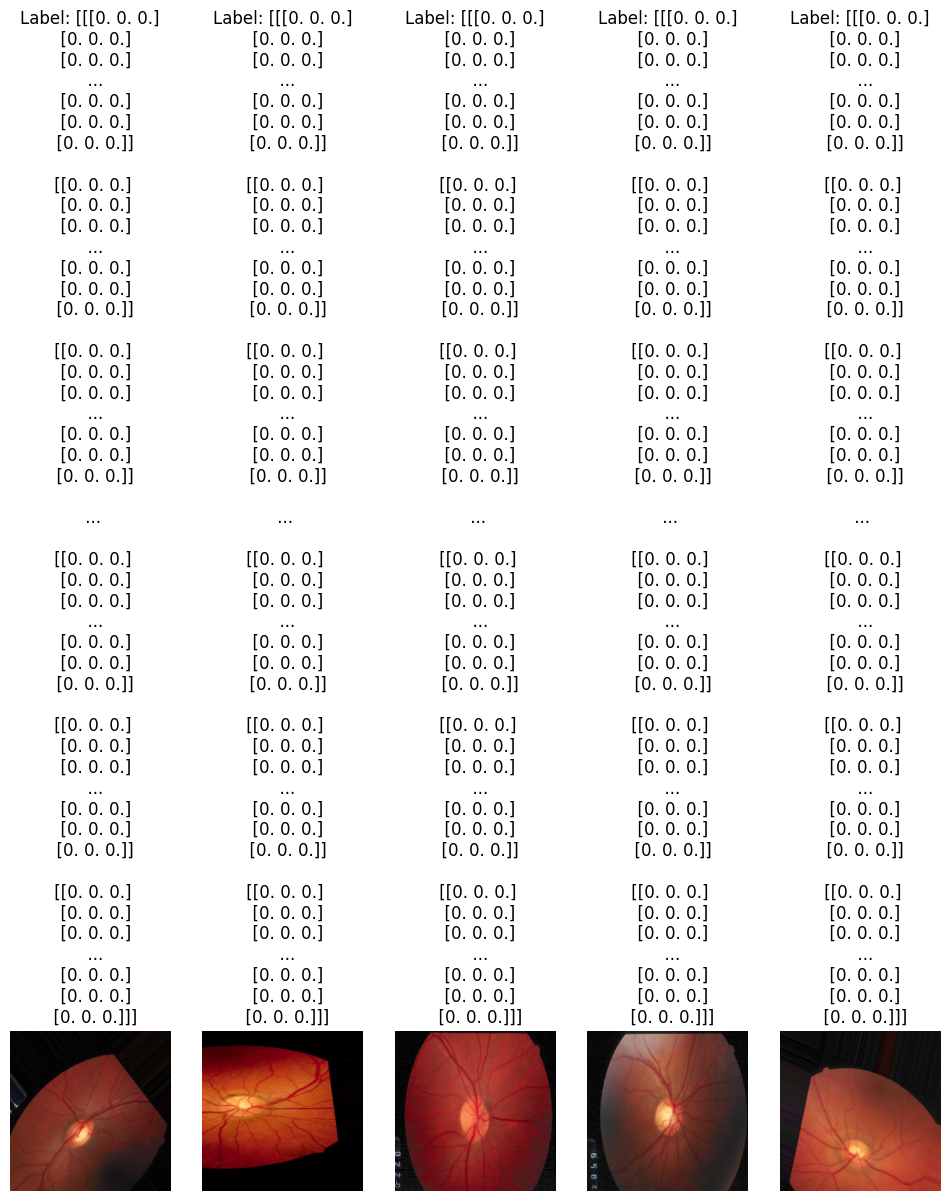

In [9]:
import matplotlib.pyplot as plt

# Display a few images with their labels
num_images = 5  # Number of images to display
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(12, 6))

for i in range(num_images):
    # Display the image
    axes[i].imshow(train_images[i])  # Assuming train_images contains the input images
    axes[i].axis('off')

    # Display the label
    axes[i].set_title(f"Label: {train_labels[i]}")  # Assuming train_labels contains the corresponding labels

plt.tight_layout()
plt.show()

In [11]:
np.shape(train_images)

(352, 256, 256, 3)

In [10]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.9 MB/s eta 0:00:00


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.image import resize
from tensorflow.keras.metrics import MeanIoU, Recall
from PIL import Image

# Load the pre-trained EfficientNetB0 model without the top classification layer
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Define the U-Net architecture
def unet_model(base_model):
    # Encoder
    encoder_output = base_model.get_layer('block7a_project_bn').output

    # Decoder
    upsample = layers.UpSampling2D((2, 2))(encoder_output)
    concat = layers.Concatenate()([upsample, base_model.get_layer('block6a_expand_bn').output])
    conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(concat)
    conv2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)

    upsample = layers.UpSampling2D((2, 2))(conv2)
    concat = layers.Concatenate()([upsample, base_model.get_layer('block4a_expand_bn').output])
    conv1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(concat)
    conv2 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)

    upsample = layers.UpSampling2D((2, 2))(conv2)
    concat = layers.Concatenate()([upsample, base_model.get_layer('block3a_expand_bn').output])
    conv1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(concat)
    conv2 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)

    upsample = layers.UpSampling2D((2, 2))(conv2)
    concat = layers.Concatenate()([upsample, base_model.get_layer('block2a_expand_bn').output])
    conv1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(concat)
    conv2 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)

    # Output layer
    output = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv2)

    return models.Model(inputs=base_model.input, outputs=output)

# Create the U-Net model
model = unet_model(base_model)


# Custom metric for specificity
class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name='specificity', **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred > 0.5, tf.bool)

        true_negatives = tf.reduce_sum(tf.cast(tf.logical_not(tf.logical_or(y_true, y_pred)), tf.float32))
        false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(y_true), y_pred), tf.float32))

        self.true_negatives.assign_add(true_negatives)
        self.false_positives.assign_add(false_positives)

    def result(self):
        return self.true_negatives / (self.true_negatives + self.false_positives + tf.keras.backend.epsilon())

    def reset_states(self):
        self.true_negatives.assign(0.0)
        self.false_positives.assign(0.0)

# Metrics
iou = MeanIoU(num_classes=2)
sensitivity = Recall()
specificity = Specificity()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou, sensitivity, specificity])

# Resize the train_labels data to match the model's output shape
train_labels_resized = resize(train_labels, (128, 128), method='bilinear')
train_labels_resized = tf.image.rgb_to_grayscale(train_labels_resized)  # Convert to grayscale
train_labels_resized = tf.cast(train_labels_resized > 0.5, tf.float32)

# Define early stopping and learning rate scheduling callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(train_images, train_labels_resized, epochs=100, batch_size=8, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_labels_resized = resize(test_labels, (128, 128), method='bilinear')
test_labels_resized = tf.image.rgb_to_grayscale(test_labels_resized)  # Convert to grayscale
test_labels_resized = tf.cast(test_labels_resized > 0.5, tf.float32)
evaluation = model.evaluate(test_images, test_labels_resized)

print("IoU: ", evaluation[2])
print("Sensitivity: ", evaluation[3])
print("Specificity: ", evaluation[4])

Epoch 1/100
40/40 [==============================] - 13s 101ms/step - loss: 0.1777 - accuracy: 0.9681 - mean_io_u_1: 0.4847 - recall_1: 3.1597e-05 - specificity: 0.9986 - val_loss: 0.1406 - val_accuracy: 0.9687 - val_mean_io_u_1: 0.4843 - val_recall_1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 2s 51ms/step - loss: 0.1324 - accuracy: 0.9694 - mean_io_u_1: 0.4847 - recall_1: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.1237 - val_accuracy: 0.9687 - val_mean_io_u_1: 0.4843 - val_recall_1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 2s 49ms/step - loss: 0.1235 - accuracy: 0.9694 - mean_io_u_1: 0.4847 - recall_1: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.1225 - val_accuracy: 0.9687 - val_mean_io_u_1: 0.4843 - val_recall_1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 2s 47ms/step - loss: 0.1198 - accuracy: 0.

In [14]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            